In [1]:
# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
#import scipy.stats as stats
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest


# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Fase 4: Problema de A/B Testing.

El objetivo de esta fase es determinar si existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados, y si es así, cuál es la magnitud de esa relación. Partiremos de la siguiente hipótesis, "Existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa. Se sospecha que los empleados con niveles de satisfacción más bajos tienen una mayor probabilidad de dejar la empresa". Para ello deberéis crear una columna nueva en base al nivel de satisfacción en el trabajo para crear dos grupos, las condiciones para crear los grupos son:

- **Grupo A (Control):** Empleados con un nivel de satisfacción en el trabajo igual o superior a 3 en una escala de 1 a 5.

- **Grupo B (Variante):** Empleados con un nivel de satisfacción en el trabajo inferior a 3 en la misma escala.

La **métrica principal** que debes usar es la tasa de rotación de empleados (Attrition) en cada grupo. Recordemos que, en esta columna, "No" indica que el empleado no ha dejado la empresa (sin rotación), mientras que "Yes" indica que el empleado ha dejado la empresa (con rotación).

Por lo tanto, los pasos que deberás seguir en esta fase son:

1. Divide a los empleados en los grupos A y B según los criterios establecidos.

2. Calcula la tasa de rotación (porcentaje de empleados que dejaron la empresa) en cada grupo.

3. Realiza un análisis estadístico para determinar si hay una diferencia significativa en la tasa de rotación entre los grupos A y B.

4. Analiza los resultados.

5. Calcular la magnitud de esta relación utilizando estadísticas como la diferencia de medias por ejemplo.

In [6]:
# lo primero que hacemos es cargar el dataframe que vamos a usar para esta lección
df = pd.read_csv("df_imputada.csv")
df.head(2)

,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,DateBirth,RemoteWork,PerformanceRating,TotalWorkingYears,MonthlyIncome
0,no,unknown,684.0,6,3,unknown,"162,0",1,female,51.0,3,5,research_director,3,unknown,6462,7,no,13,3,0,5,3.0,20,15,15,1972,yes,3.0,32.595028,19537.0
1,no,unknown,699.0,1,4,life_sciences,"259,0",3,female,65.0,2,5,manager,3,unknown,5678,0,unknown,14,1,1,5,3.0,33,11,9,1971,yes,3.0,34.000000,19999.0


In [13]:
df['JobSatisfaction'].unique()

array([3, 4, 1, 2])

Tasa de rotación en Grupo A: 13.67%
Tasa de rotación en Grupo B: 19.87%
P-valor de la prueba t:  0.0


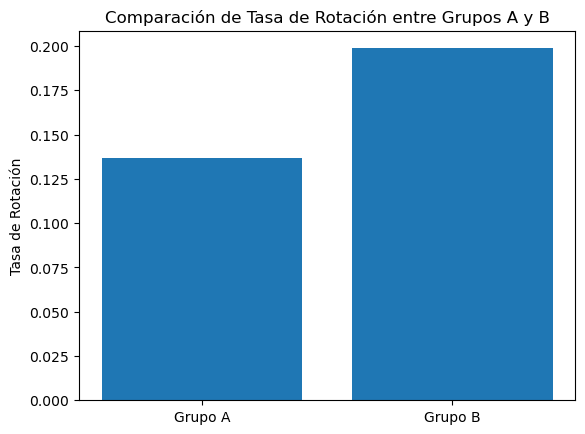

In [15]:
df = pd.DataFrame(df)

# Divide a los empleados en grupos A y B
grupo_A = df[df['JobSatisfaction'] >= 3]
grupo_B = df[df['JobSatisfaction'] < 3]

# Calcula la tasa de rotación en cada grupo
tasa_rotacion_A = grupo_A['Attrition'].value_counts(normalize=True)['yes']
tasa_rotacion_B = grupo_B['Attrition'].value_counts(normalize=True)['yes']

# Realiza una prueba de hipótesis (prueba t de Student)
t_stat, p_value = stats.ttest_ind(grupo_A['JobSatisfaction'], grupo_B['JobSatisfaction'])

# Imprime los resultados
print(f"Tasa de rotación en Grupo A: {tasa_rotacion_A:.2%}")
print(f"Tasa de rotación en Grupo B: {tasa_rotacion_B:.2%}")
print(f"P-valor de la prueba t: {p_value: 0.05}")

# Visualiza los datos
plt.bar(['Grupo A', 'Grupo B'], [tasa_rotacion_A, tasa_rotacion_B])
plt.ylabel('Tasa de Rotación')
plt.title('Comparación de Tasa de Rotación entre Grupos A y B')
plt.show()

In [14]:
# Dividir en grupos A y B según la satisfacción en el trabajo
df['Group'] = df['JobSatisfaction'].apply(lambda x: 'A' if x >= 3 else 'B')

# Calcular la tasa de rotación para cada grupo
attrition_rates = df.groupby('Group')['Attrition'].apply(lambda x: (x == 'Yes').mean())

# Mostrar las tasas de rotación
print(attrition_rates)

# Análisis estadístico: Prueba de diferencia de proporciones
# Crear tablas de contingencia
contingency_table = pd.crosstab(df['Attrition'], df['Group'])

# Realizar la prueba de diferencia de proporciones
chi2, p, dof, ex = stats.chi2_contingency(contingency_table, correction=False)

# Mostrar resultados del análisis
print(f"Chi2: {chi2}, p-value: {p}")

Group
A    0.0
B    0.0
Name: Attrition, dtype: float64
Chi2: 10.896830732804563, p-value: 0.0009632893461685967


Prueba t de Student
T-Test Independiente:
- Normalidad en ambos grupos.
- Homogeneidad de varianza en ambos grupos


en general observamos que hay tres:

- Normalidad (Prueba de Shapiro-Wilk o Prueba Kolmogorov-Smirnov) - Verificar si los datos siguen una distribución normal.

- Homogeneidad de varianzas (Prueba de Levene o Prueba de Bartlett) - Verificar si las varianzas son homogéneas entre grupos.

- Independencia entre las observaciones

In [18]:
# vamos a definir una función para poder hacer el t-test de Student

def prueba_hipotesis(*args):
    
    # lo primero que tenemos que hacer es mirar si las varianzas son iguales o no
    if len(args) == 2:
        p_valor_varianza = stats.levene(*args, center = "median")[1]
    else:
        p_valor_varianza = stats.bartlett(*args)[1]
    
    if p_valor_varianza > 0.05:
        # realizamos la prueba t de Student
        t_stat, p_valor = stats.ttest_ind(*args, equal_var=True)
    else:
        t_stat, p_valor = stats.ttest_ind(*args, equal_var=False)
        
    # Establecemos un nivel de significancia (alfa)
    alfa = 0.05

    # comparamos el p-valor con el nivel de significancia
    if p_valor < alfa:
        print("Rechazamos la hipótesis nula.")
        print("Hay una diferencia significativa en el nivel de satisfaccion promedio entre los dos grupos.")
    else:
        print("No podemos rechazar la hipótesis nula.")
        print("No hay evidencia suficiente para afirmar una diferencia significativa en el nivel de satisfaccion promedio entre los dos grupos.")
        
# filtramos los datos para obtener dos grupos: 
grupo_A = df[df['Attrition'] == 'yes']['JobSatisfaction']
grupo_B = df[df['Attrition'] == 'no']['JobSatisfaction']

# llamamos a la función que hemos creado
prueba_hipotesis(grupo_A, grupo_B)

Rechazamos la hipótesis nula.
Hay una diferencia significativa en el nivel de satisfaccion promedio entre los dos grupos.


In [21]:
# Divide a los empleados en grupos A y B
grupo_A = df[df['Attrition'] == 'yes']['JobSatisfaction']
grupo_B = df[df['Attrition'] == 'no']['JobSatisfaction']

In [22]:
#Calculo de la tasa de conversion:
# Calcular la tasa de conversión para el grupo A ("ad")
JobSatisfaction_A = grupo_A["JobSatisfaction"].sum()
total_users_A = len(grupo_A)
conversion_rate_A = JobSatisfaction_A / total_users_A
print(f"Tasa de conversión para el grupo 'ad': {conversion_rate_A:.2%}")

# Calcular la tasa de conversión para el grupo B ("psa")
JobSatisfaction_B = grupo_B["JobSatisfaction"].sum()
total_users_B = len(grupo_B)
conversion_rate_B = JobSatisfaction_B / total_users_B
print(f"Tasa de conversión para el grupo 'psa': {conversion_rate_B:.2%}")

KeyError: 'JobSatisfaction'